In [23]:
# READING USERS DF

import pandas as pd
import numpy as np
import os
os.chdir("c://Users//gufer//OneDrive//Documentos//FIAP//Fase_05//ML_Engineer_Datathon/")

users = pd.read_parquet("data/processed_data/features/users_feats.parquet")

In [22]:
TARGET_COLS = [
    "userId",
    "pageId",
    "numberOfClicksHistory",
    "timeOnPageHistory",
    "coldStart",
    "scrollPercentageHistory",
    "pageVisitsCountHistory",
    "minutesSinceLastVisit",
    "coldStart"
]

df_users = users[TARGET_COLS]
df_users.describe()

,numberOfClicksHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,minutesSinceLastVisit
count,808078.000000,8.080780e+05,808078.000000,808078.000000,808078.000000
mean,11.867999,8.782915e+04,53.315640,1.132347,1187.429810
std,37.695612,1.118131e+05,1776.596766,1.207914,3717.990234
min,0.000000,5.000000e+03,0.240000,1.000000,0.000000
25%,0.000000,2.985900e+04,26.820000,1.000000,2.000000
50%,1.000000,6.000000e+04,43.080000,1.000000,47.000000
75%,13.000000,1.130170e+05,59.750000,1.000000,915.000000
max,13476.000000,2.900904e+07,470156.810000,654.000000,63703.000000


In [24]:
def _create_target(df_users: pd.DataFrame) -> pd.DataFrame:
    """Gera a coluna TARGET padronizada de forma menos sensível a outliers (robust scaling)."""
    
    # Agrega usando diferentes estratégias de agrupamento
    agg_df = df_users.groupby('userId', as_index=False).agg({
        'numberOfClicksHistory': 'sum',
        'timeOnPageHistory': 'sum',
        'scrollPercentageHistory': 'mean',
        'pageVisitsCountHistory': 'sum',
        'minutesSinceLastVisit': 'mean'
    })
    
    # Aplica transformação logarítmica para reduzir a influência de outliers
    agg_df['pageVisitsTransformed'] = np.log1p(agg_df['pageVisitsCountHistory'])
    
    # Cálculo do TARGET com pesos ajustados, usando a versão transformada de pageVisitsCountHistory
    agg_df['TARGET'] = (
        agg_df['numberOfClicksHistory'] +
        1.5 * (agg_df['timeOnPageHistory'] / 500) +
        agg_df['scrollPercentageHistory'] +
        2 * agg_df['pageVisitsTransformed'] -
        (agg_df['minutesSinceLastVisit'] / 20)
    )
    
    # Calcula a mediana dos valores de 'TARGET'
    median_val = agg_df['TARGET'].median()

    # Calcula o intervalo interquartil (IQR)
    iqr_val = agg_df['TARGET'].quantile(0.75) - agg_df['TARGET'].quantile(0.25)

    # Se o IQR for zero (todos os valores iguais, por exemplo), apenas subtrai a mediana
    # Caso contrário, padroniza (robust scaling) subtraindo a mediana e dividindo pelo IQR
    if iqr_val == 0:
        agg_df['TARGET'] = agg_df['TARGET'] - median_val
    else:
        agg_df['TARGET'] = (agg_df['TARGET'] - median_val) / iqr_val

    # Mescla os valores padronizados de 'TARGET' de volta ao DataFrame original
    target_df = df_users.merge(agg_df[['userId', 'TARGET']], on='userId', how='left')

    return target_df

target_df = _create_target(df_users)
target_df

,userId,pageId,numberOfClicksHistory,timeOnPageHistory,coldStart,scrollPercentageHistory,pageVisitsCountHistory,minutesSinceLastVisit,coldStart,TARGET
0,00011b1ced626112372206634e0e9b5ccb432da916e83f...,c9b148e7-72fa-416e-84ac-a4499abc7aaf,0,14071,True,23.46,1,0.0,True,-0.190421
1,00012cd490cea9fe043146807def18c830fa0d0b791772...,5a5e2555-ac88-4882-9dc2-e19bb392a448,0,50000,True,56.08,1,0.0,True,0.166289
2,00012cd490cea9fe043146807def18c830fa0d0b791772...,3363b054-df39-4e3d-b2b3-dd3cb227dd55,0,52647,True,59.64,1,1.0,True,0.166289
3,00012cd490cea9fe043146807def18c830fa0d0b791772...,e81de120-5005-4a01-8b63-90018005903e,0,60000,True,42.28,1,34.0,True,0.166289
4,00024d84a3d619b1972e9dd5efa9c930557d85f6463fd6...,c274ed4b-e679-41ce-9dfb-c53874916511,11,32436,True,46.58,1,0.0,True,-0.123527
...,...,...,...,...,...,...,...,...,...,...
808073,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,fb5459eb-d86b-447e-83d5-0172fbab1ecd,0,10000,False,39.53,1,13.0,False,3.668507
808074,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,2e3300c6-3a18-4908-b9a9-a955cfcdcfcc,0,50000,False,34.46,2,5716.0,False,3.668507
808075,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,1ca0b64a-8bb4-4a2b-b3d0-af935960bf15,0,10000,False,7.05,1,619.0,False,3.668507
808076,ffff2c95e9c668ba32f163d1b2573ae67c95ea49e7b380...,331bc28e-4e05-425e-8914-766606dfdf88,0,50000,False,21.99,1,1178.0,False,3.668507


In [25]:
# Target: ENGAGEMENT_SCORE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_target_distribution(df):
    """Plota a distribuição da variável TARGET."""
    plt.figure(figsize=(10, 5))
    sns.histplot(df['TARGET'], bins=50, kde=True)
    plt.xlabel('TARGET (Engajamento Padronizado)')
    plt.ylabel('Frequência')
    plt.title('Distribuição da Variável TARGET')
    plt.grid(True)
    plt.show()

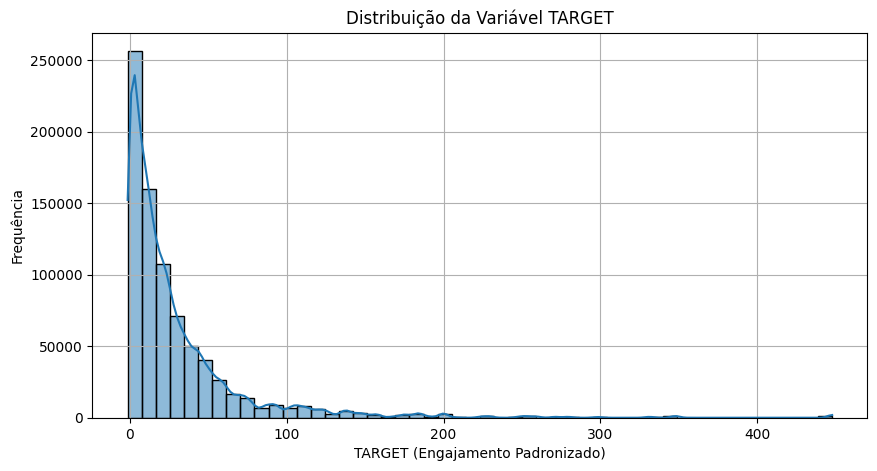

In [26]:
plot_target_distribution(target_df)